# Lightning Creek Sill Complex, Australia - Airborne total-field magnetic anomaly grid

This is a gridded version of the Lightning Creek anomaly from [our Osborne Mine dataset](https://github.com/fatiando-data/osborne-magnetic). The anomaly is very visible and presents interesting processing and modelling challenges. The grid was generated using [gradient-boosted equivalent sources](https://www.fatiando.org/harmonica/v0.5.1/user_guide/equivalent_sources/gradient-boosted-eqs.html). It's a regular grid in UTM coordinates at a constant height of 500 m. Having the gridded version allows us to use it for FFT-based examples and other applications that require a grid (without having to interpolate every time we need it).

**Source:** Geophysical Acquisition & Processing Section 2019. MIM Data from Mt Isa Inlier, QLD (P1029), magnetic line data, AWAGS levelled. Geoscience Australia, Canberra. http://pid.geoscience.gov.au/dataset/ga/142419

**License:** [CC-BY](http://pid.geoscience.gov.au/dataset/ga/142419)

## Notes

🚨 **WARNING:** 🚨 This notebook can take 2h or more to run the interpolation. Make sure you adjust the window size in the `EquivalentSourcesGB` to suite the RAM available on your machine.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import verde as vd
import harmonica as hm
import pooch
import pygmt
import pyproj

## Download the data

Use [Pooch](https://github.com/fatiando/pooch) to download the original data file to our computer.

In [2]:
fname = pooch.retrieve(
    url="doi:10.5281/zenodo.5882209/osborne-magnetic.csv.xz",
    known_hash="md5:b26777bdde2f1ecb97dda655c8b1cf71",
)
print(f"size: {os.path.getsize(fname) / 1e6} Mb")

size: 2.214076 Mb


## Read the data

Use pandas to read the data.

In [3]:
data_full = pd.read_csv(fname)
data_full

,flight_line,longitude,latitude,height_orthometric_m,total_field_anomaly_nt
0,5576,140.66411,-21.86833,367,-124
1,5576,140.66403,-21.86832,367,-124
2,5576,140.66394,-21.86832,367,-124
3,5576,140.66385,-21.86832,366,-124
4,5576,140.66377,-21.86832,366,-124
...,...,...,...,...,...
990982,10166,140.50757,-21.87023,382,-67
990983,10166,140.50757,-21.87029,382,-66
990984,10166,140.50758,-21.87034,383,-66
990985,10166,140.50758,-21.87040,383,-66


## Project to UTM

Project the data to UTM so we can generate a Cartesian grid.

In [4]:
projection = pyproj.Proj("+proj=utm +zone=54 +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
data_full["easting"], data_full["northing"] = projection(data_full.longitude, data_full.latitude)
data_full

,flight_line,longitude,latitude,height_orthometric_m,total_field_anomaly_nt,easting,northing
0,5576,140.66411,-21.86833,367,-124,465297.091381,7.581709e+06
1,5576,140.66403,-21.86832,367,-124,465288.823592,7.581710e+06
2,5576,140.66394,-21.86832,367,-124,465279.525048,7.581710e+06
3,5576,140.66385,-21.86832,366,-124,465270.226503,7.581710e+06
4,5576,140.66377,-21.86832,366,-124,465261.961130,7.581710e+06
...,...,...,...,...,...,...,...
990982,10166,140.50757,-21.87023,382,-67,449124.388979,7.581455e+06
990983,10166,140.50757,-21.87029,382,-66,449124.410242,7.581449e+06
990984,10166,140.50758,-21.87034,383,-66,449125.461133,7.581443e+06
990985,10166,140.50758,-21.87040,383,-66,449125.482395,7.581436e+06


## Select just the Lightning Creek anomaly

Slice the data to isolate it and reduce the amount of data a bit.

In [5]:
geographic_region = [140 + 40/60, 140 + 50/60, -(21 + 55/60), -(21 + 45/60)]
data = data_full[vd.inside((data_full.longitude, data_full.latitude), geographic_region)].reset_index(drop=True)
coordinates = (data.easting, data.northing, data.height_orthometric_m)
region = vd.get_region(coordinates)
data

,flight_line,longitude,latitude,height_orthometric_m,total_field_anomaly_nt,easting,northing
0,9728,140.66672,-21.88426,360,-55,465570.570728,7.579946e+06
1,9728,140.66678,-21.88426,360,-56,465576.769067,7.579946e+06
2,9728,140.66684,-21.88426,361,-56,465582.967407,7.579946e+06
3,9728,140.66690,-21.88426,362,-56,465589.165747,7.579946e+06
4,9728,140.66696,-21.88426,362,-57,465595.364087,7.579946e+06
...,...,...,...,...,...,...,...
258489,10156,140.68201,-21.75024,414,285,467119.516102,7.594784e+06
258490,10156,140.68201,-21.75018,414,278,467119.502444,7.594790e+06
258491,10156,140.68201,-21.75012,417,270,467119.488786,7.594797e+06
258492,10156,140.68201,-21.75006,417,263,467119.475128,7.594804e+06


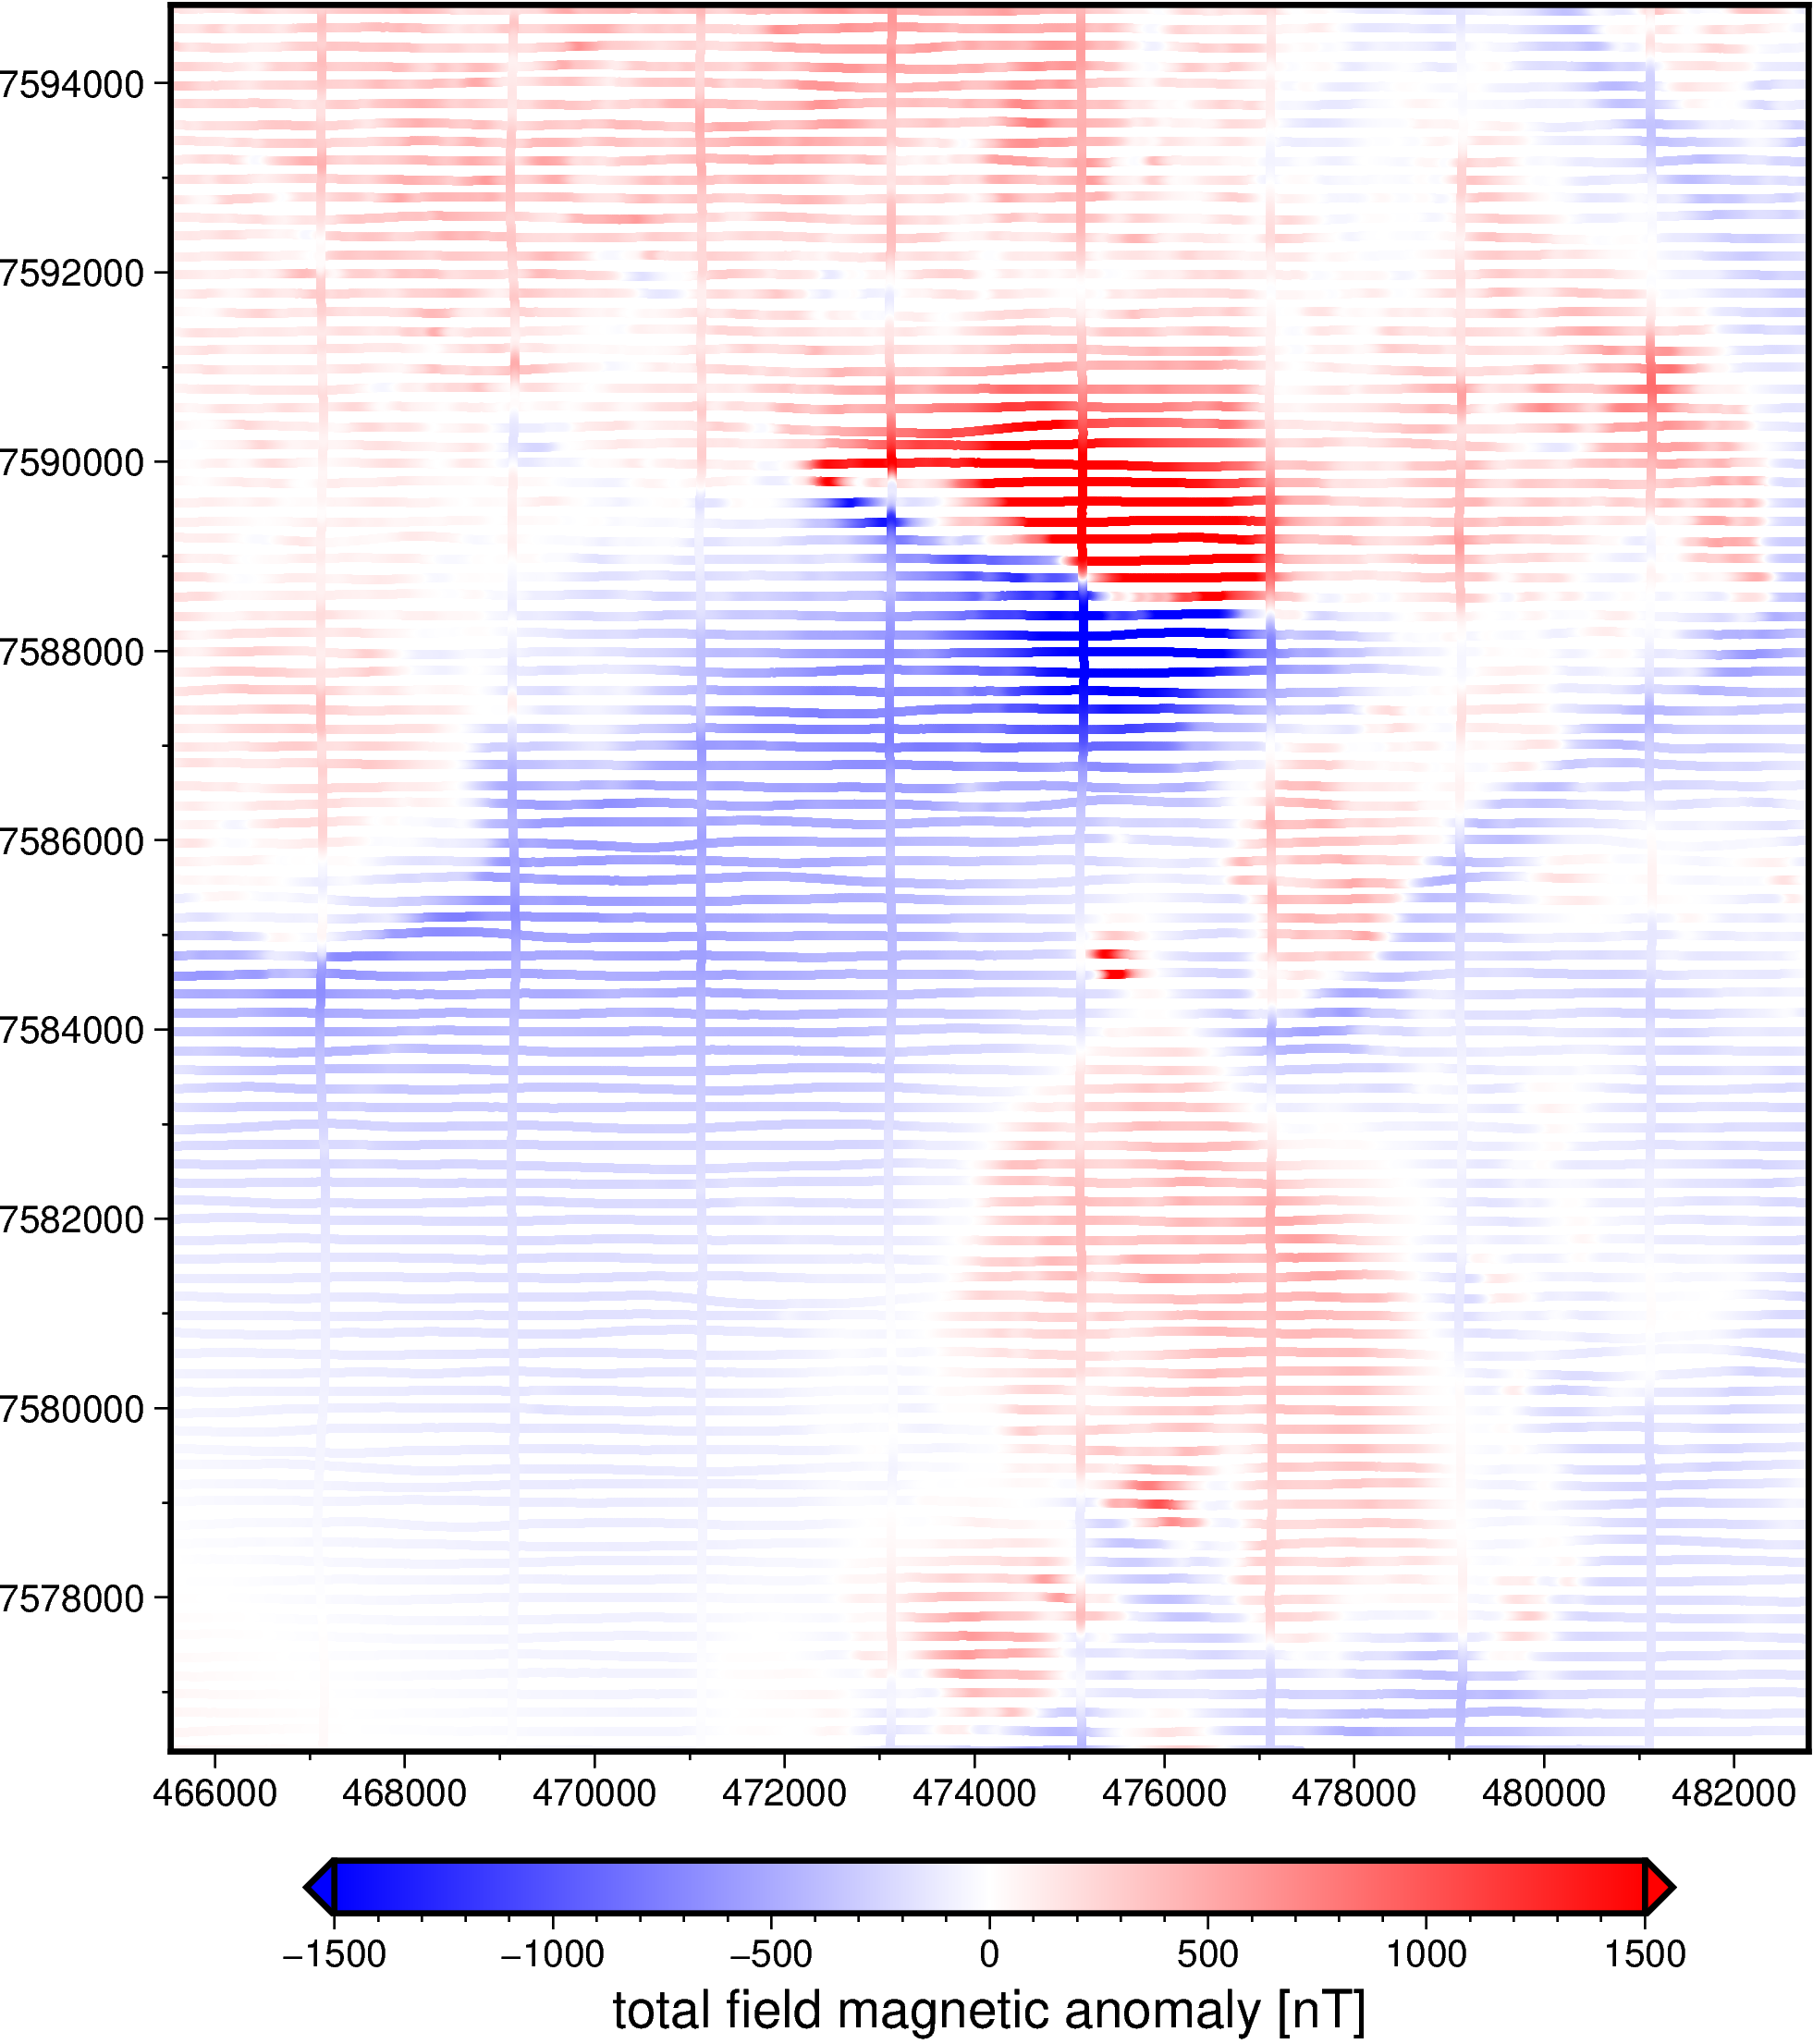

In [6]:
fig = pygmt.Figure()
scale = 1500
pygmt.makecpt(cmap="polar+h", series=[-scale, scale], background=True)
fig.plot(
    x=data.easting,
    y=data.northing,
    color=data.total_field_anomaly_nt,
    style="c0.075c",
    cmap=True,
    projection="X15c/16c", 
    region=region, 
    frame="af",
)
fig.colorbar(
    frame='af+l"total field magnetic anomaly [nT]"', 
    position="JBC+h+o0/1c+e",
)
fig.show()

## Interpolate

Interpolate the data onto a regular grid at constant height. Height will be set to 500 m to avoid downward continuing data. To do so, we'll use the `hm.EquivalentSourcesGB` class from Harmonica. The `window_size` is set to limit the amount of RAM used in the interpolation to about 5 Gb. If you have less memory available, decrease the window size.

In [7]:
spacing = 50
eqs = hm.EquivalentSourcesGB(damping=1e-4, depth=150, block_size=spacing, window_size=8e3, dtype="float32")

In [8]:
%%time
eqs.fit(coordinates, data.total_field_anomaly_nt)

CPU times: user 7h 9min 40s, sys: 2h 10min 35s, total: 9h 20min 15s
Wall time: 1h 52min 21s


EquivalentSourcesGB(block_size=50, damping=0.0001, depth=150, dtype='float32',
                    window_size=8000.0)

In [9]:
grid_coordinates = vd.grid_coordinates(region, spacing=spacing, adjust="region", extra_coords=500)
grid = eqs.grid(
    grid_coordinates, 
    dims=["northing", "easting"],
    data_names="total_field_anomaly",
).rename({"upward": "height"}).total_field_anomaly
grid

<xarray.DataArray 'total_field_anomaly' (northing: 370, easting: 346)>
array([[  35.035896 ,   36.22267  ,   36.686024 , ..., -101.14571  ,
        -100.3659   ,  -99.59024  ],
       [  36.47112  ,   37.626167 ,   38.047474 , ..., -102.1968   ,
        -101.45823  , -100.71167  ],
       [  37.08598  ,   38.19683  ,   38.594013 , ..., -103.319046 ,
        -102.61533  , -101.90473  ],
       ...,
       [ 182.78972  ,  172.43317  ,  160.79646  , ...,    0.8423192,
         -24.223671 ,  -41.77879  ],
       [ 182.1444   ,  172.59451  ,  161.4123   , ...,    6.018458 ,
         -21.48813  ,  -41.030308 ],
       [ 178.77835  ,  170.41621  ,  160.28114  , ...,   11.370348 ,
         -16.031101 ,  -35.835255 ]], dtype=float32)
Coordinates:
  * easting   (easting) float64 4.655e+05 4.656e+05 ... 4.827e+05 4.828e+05
  * northing  (northing) float64 7.576e+06 7.576e+06 ... 7.595e+06 7.595e+06
    height    (northing, easting) float64 500.0 500.0 500.0 ... 500.0 500.0
Attributes:
    metadata:  Generated by EquivalentSourcesGB(block_size=50, damping=0.0001...

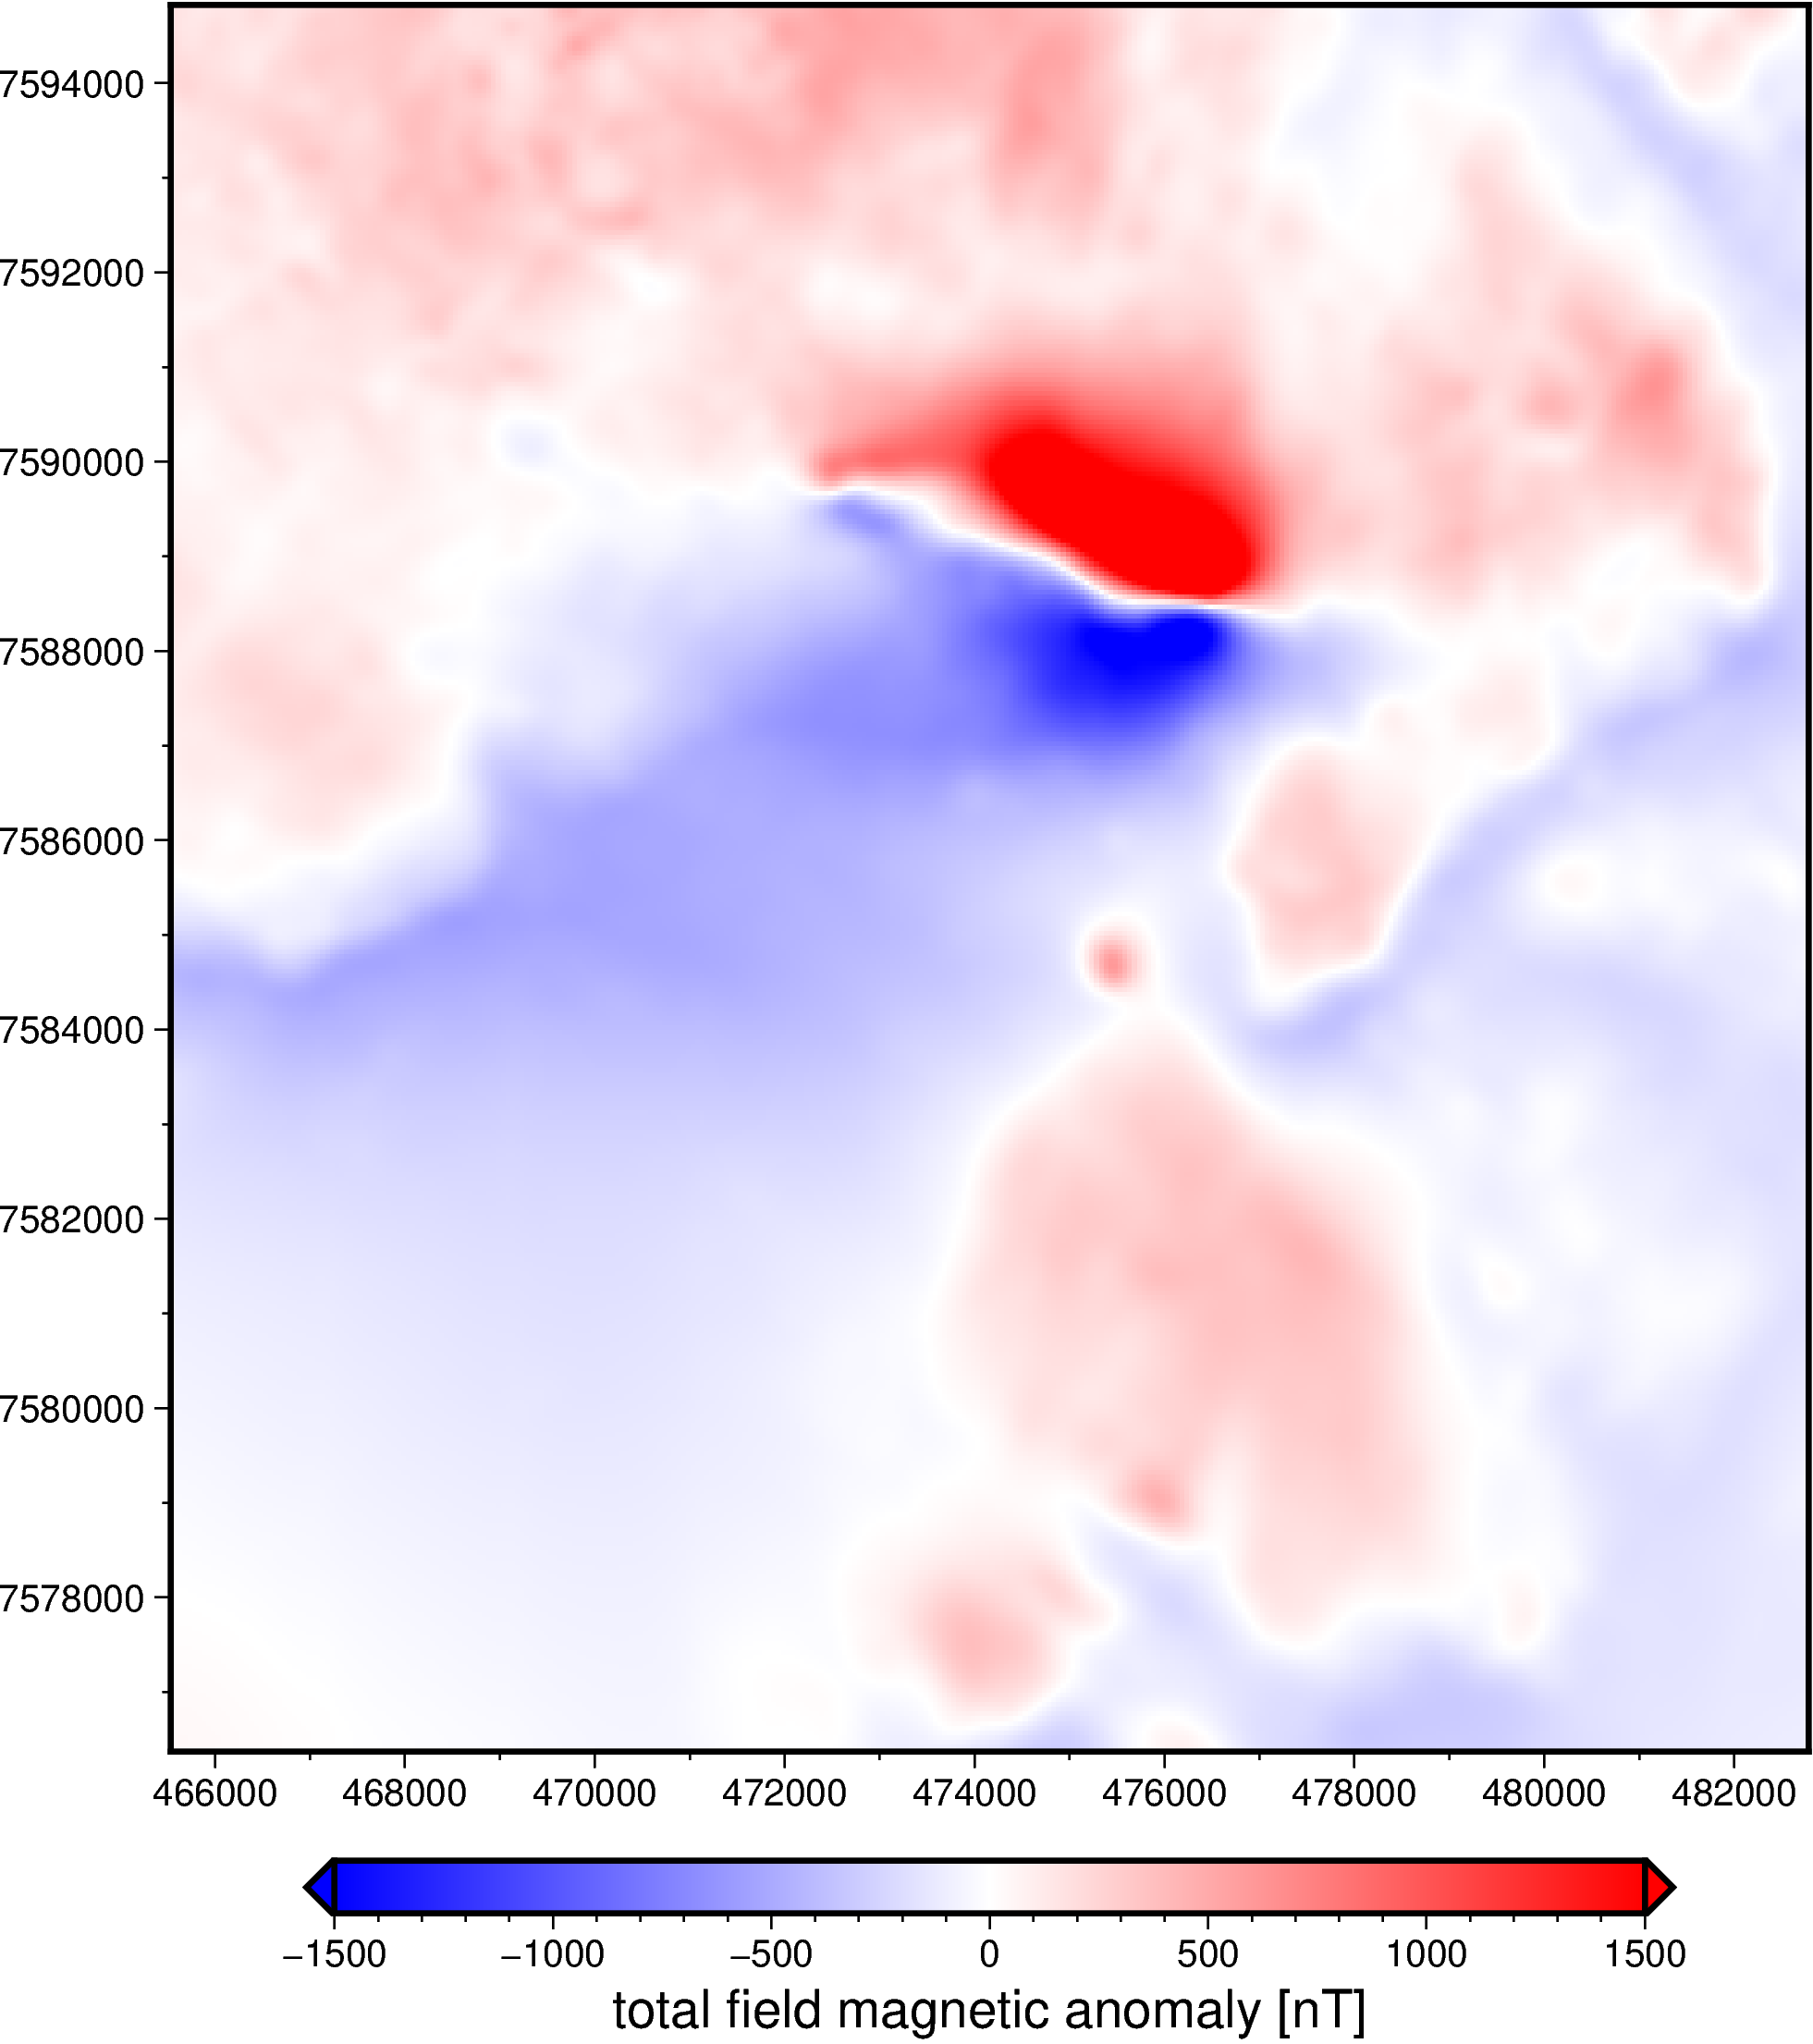

In [10]:
fig = pygmt.Figure()
scale = 1500
pygmt.makecpt(cmap="polar+h", series=[-scale, scale], background=True)
fig.grdimage(
    grid=grid, 
    cmap=True,
    projection="X15c/16c", 
    region=region, 
    frame="af",
)
fig.colorbar(
    frame='af+l"total field magnetic anomaly [nT]"', 
    position="JBC+h+o0/1c+e",
)
fig.savefig("preview.jpg")
fig.show()

## Set proper metadata

Add metadata and proper field names to the grid before saving.

In [11]:
def minmax_round(grid, decimals):
    """
    Return the minimum and maximum values in the grid 
    rounded to *decimal* places.
    """
    vmin = np.round(grid.values.min(), decimals=decimals)
    vmax = np.round(grid.values.max(), decimals=decimals)
    return (vmin, vmax)

In [12]:
grid.attrs = {
    "Conventions": "CF-1.8",
    "title": "Magnetic total-field anomaly of the Lightning Creek sill complex, Australia",
    "crs": str(projection),
    "source": "Interpolated from airborne magnetic line data using gradient-boosted equivalent sources",
    "license": "Creative Commons Attribution 4.0 International Licence",
    "references": "Geophysical Acquisition & Processing Section 2019. MIM Data from Mt Isa Inlier, QLD (P1029), magnetic line data, AWAGS levelled. Geoscience Australia, Canberra. http://pid.geoscience.gov.au/dataset/ga/142419",
    "long_name": "total-field magnetic anomaly",
    "units": "nT",
    "actual_range": minmax_round(grid, decimals=0),
}
grid.height.attrs = {
    "long_name": "orthometric height",
    "standard_name": "height_above_geopotential_datum",
    "units": "m",
    "actual_range": (grid.height.values.min(), grid.height.values.max()),
}
grid.easting.attrs = {
    "long_name": "UTM easting",
    "standard_name": "projection_x_coordinate",
    "units": "m",
    "actual_range": (grid.easting.values.min(), grid.easting.values.max()),
}
grid.northing.attrs = {
    "long_name": "UTM northing",
    "standard_name": "projection_y_coordinate",
    "units": "m",
    "actual_range": (grid.northing.values.min(), grid.northing.values.max()),
}
grid

<xarray.DataArray 'total_field_anomaly' (northing: 370, easting: 346)>
array([[  35.035896 ,   36.22267  ,   36.686024 , ..., -101.14571  ,
        -100.3659   ,  -99.59024  ],
       [  36.47112  ,   37.626167 ,   38.047474 , ..., -102.1968   ,
        -101.45823  , -100.71167  ],
       [  37.08598  ,   38.19683  ,   38.594013 , ..., -103.319046 ,
        -102.61533  , -101.90473  ],
       ...,
       [ 182.78972  ,  172.43317  ,  160.79646  , ...,    0.8423192,
         -24.223671 ,  -41.77879  ],
       [ 182.1444   ,  172.59451  ,  161.4123   , ...,    6.018458 ,
         -21.48813  ,  -41.030308 ],
       [ 178.77835  ,  170.41621  ,  160.28114  , ...,   11.370348 ,
         -16.031101 ,  -35.835255 ]], dtype=float32)
Coordinates:
  * easting   (easting) float64 4.655e+05 4.656e+05 ... 4.827e+05 4.828e+05
  * northing  (northing) float64 7.576e+06 7.576e+06 ... 7.595e+06 7.595e+06
    height    (northing, easting) float64 500.0 500.0 500.0 ... 500.0 500.0
Attributes:
    Conventions:   CF-1.8
    title:         Magnetic total-field anomaly of the Lightning Creek sill c...
    crs:           proj=utm zone=54 south datum=WGS84 units=m no_defs ellps=W...
    source:        Interpolated from airborne magnetic line data using gradie...
    license:       Creative Commons Attribution 4.0 International Licence
    references:    Geophysical Acquisition & Processing Section 2019. MIM Dat...
    long_name:     total-field magnetic anomaly
    units:         nT
    actual_range:  (-1785.0, 3798.0)

## Export

Save the grid to a netCDF file and calculate the size and MD5/SHA256 hashes.

Use compression (both zlib and discretization based) to reduce the file sizes. The `scale_factor` determines the amount of decimal places retained when converting floats into integers. See http://xarray.pydata.org/en/stable/user-guide/io.html#writing-encoded-data

In [13]:
output = "lightning-creek-magnetic-grid.nc"
grid.to_netcdf(
    output, 
    format="NETCDF4",
    encoding={
        'total_field_anomaly': {
            "zlib": True, 
            'dtype': 'uint16', 
            'scale_factor': 0.1, 
            '_FillValue': 65000, 
            'add_offset': np.round(grid.values.min(), decimals=1),
        },
        'height': {
            "zlib": True, 
        },
    }
)
print(f"file: {output}")
print(f"size: {os.path.getsize(output) / 1e6} Mb")
for alg in ["md5", "sha256"]:
    print(f"{alg}:{pooch.file_hash(output, alg=alg)}")


file: lightning-creek-magnetic-grid.nc
size: 0.183298 Mb
md5:4b19c2eabe75865183964983861cbf68
sha256:d83f5d89f82cee128227746e2edab4498d37a3904c4770752135b7972d64629f


## Read back the data and plot it

Verify that the output didn't corrupt anything.

In [14]:
data_reloaded = xr.load_dataarray(output)
data_reloaded

<xarray.DataArray 'total_field_anomaly' (northing: 370, easting: 346)>
array([[  35.        ,   36.19995   ,   36.69995   , ..., -101.099976  ,
        -100.400024  ,  -99.599976  ],
       [  36.5       ,   37.599976  ,   38.        , ..., -102.20007   ,
        -101.5       , -100.70007   ],
       [  37.099976  ,   38.19995   ,   38.599976  , ..., -103.30005   ,
        -102.599976  , -101.900024  ],
       ...,
       [ 182.79993   ,  172.40002   ,  160.79993   , ...,    0.79992676,
         -24.200073  ,  -41.80005   ],
       [ 182.09998   ,  172.59998   ,  161.40002   , ...,    6.        ,
         -21.5       ,  -41.        ],
       [ 178.79993   ,  170.40002   ,  160.29993   , ...,   11.400024  ,
         -16.        ,  -35.80005   ]], dtype=float32)
Coordinates:
  * easting   (easting) float64 4.655e+05 4.656e+05 ... 4.827e+05 4.828e+05
  * northing  (northing) float64 7.576e+06 7.576e+06 ... 7.595e+06 7.595e+06
    height    (northing, easting) float64 500.0 500.0 500.0 ... 500.0 500.0
Attributes:
    Conventions:   CF-1.8
    title:         Magnetic total-field anomaly of the Lightning Creek sill c...
    crs:           proj=utm zone=54 south datum=WGS84 units=m no_defs ellps=W...
    source:        Interpolated from airborne magnetic line data using gradie...
    license:       Creative Commons Attribution 4.0 International Licence
    references:    Geophysical Acquisition & Processing Section 2019. MIM Dat...
    long_name:     total-field magnetic anomaly
    units:         nT
    actual_range:  [-1785.  3798.]

Make the figure again but don't save it to a file this time.

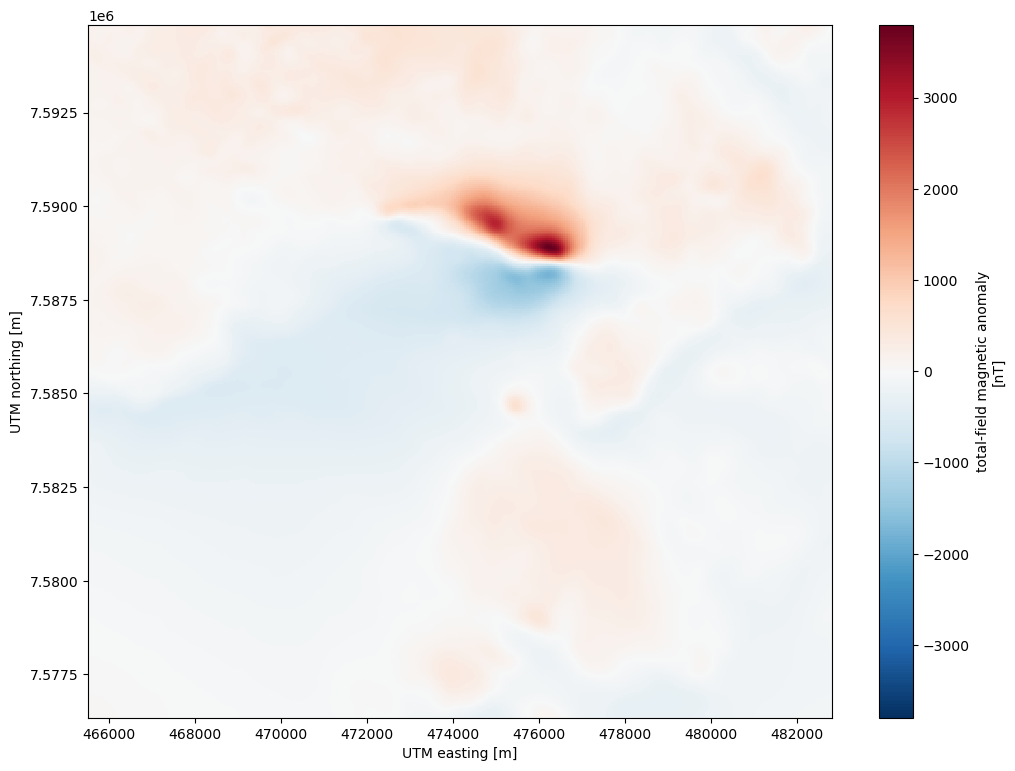

In [15]:
data_reloaded.plot(figsize=(12, 9))